In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:

# View all of the classes that automap found
for class_name in Base.classes.keys():
    print(f"Class: {class_name}, Table: {Base.classes[class_name]}")

Class: station, Table: <class 'sqlalchemy.ext.automap.station'>
Class: measurement, Table: <class 'sqlalchemy.ext.automap.measurement'>


In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create a session instance
session = Session(engine)

In [10]:
# Close Session
session.close()

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).first()
most_recent_date


('2017-08-23',)

Text(0, 0.5, 'Inches')

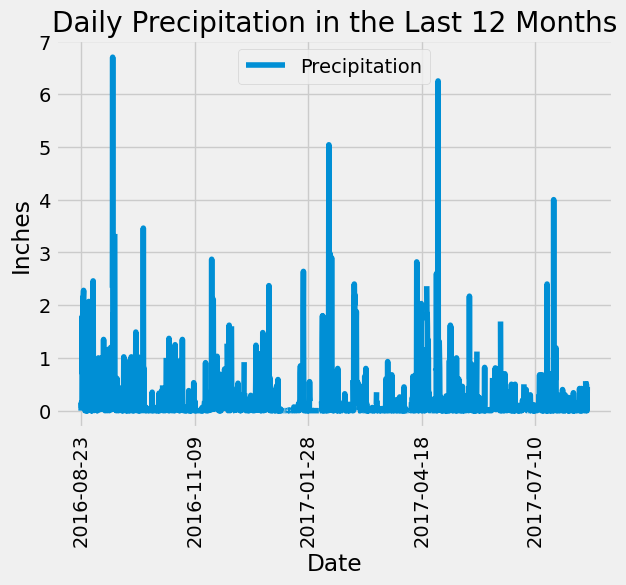

In [12]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Retrieve the most recent date
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date_obj = datetime.strptime(most_recent_date, "%Y-%m-%d")

# Calculate the date one year ago
one_year_ago = most_recent_date_obj - relativedelta(years=1)

# Query the data for the last 12 months
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago.strftime('%Y-%m-%d')).\
    order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame
df = pd.DataFrame(results, columns=["Date", "Precipitation"])

# Convert the 'Date' column to datetime type and sort the DataFrame by date
df = df.sort_values(by="Date")

# Option 1: Plot daily precipitation data with formatted x-axis
df.plot(x='Date', y='Precipitation', rot=90)
plt.title('Daily Precipitation in the Last 12 Months')
plt.xlabel("Date")
plt.ylabel("Inches")


In [13]:

import pandas as pd

# Calculate summary statistics for the 'Precipitation' column
summary_statistics = df['Precipitation'].describe()

# Print the summary statistics
(summary_statistics)


count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

In [14]:
# Close Session
session.close()

# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
from sqlalchemy import func

# Query the total number of stations
total_stations = session.query(func.count(Station.id)).scalar()  # Assuming 'id' is the column for station identifier

# Print the result
print(f"Total number of stations: {total_stations}")


Total number of stations: 9


In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

# Query to find the most active stations (stations with the most rows in the Measurement table)
active_stations = session.query(Measurement.station, func.count(Measurement.station).label('count'))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .all()

# Print the stations and their counts
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")


Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [17]:

# Most active station ID (from the previous query)
most_active_station_id = "USC00519281"  # Replace this with the actual station ID

# Query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(
    func.min(Measurement.tobs).label('lowest_temp'),
    func.max(Measurement.tobs).label('highest_temp'),
    func.avg(Measurement.tobs).label('average_temp')
).filter(Measurement.station == most_active_station_id).all()

# Extract the results
lowest_temp, highest_temp, average_temp = temperature_stats[0]

# Print the results
print(f"Station: {most_active_station_id}")
print(f"Lowest Temperature: {lowest_temp}°F")
print(f"Highest Temperature: {highest_temp}°F")
print(f"Average Temperature: {average_temp:.2f}°F")


Station: USC00519281
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


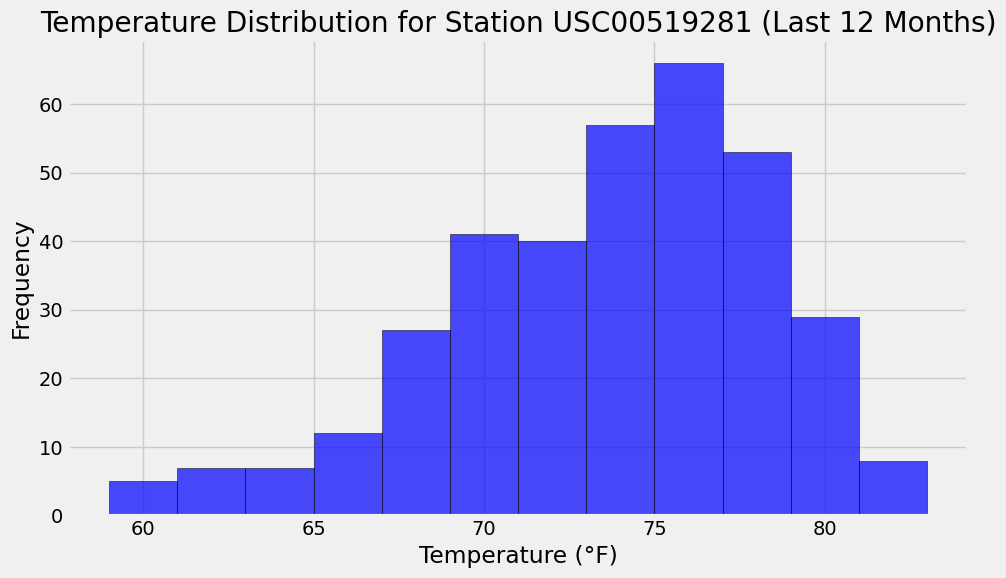

In [18]:

# Calculate the date one year ago (12 months)
one_year_ago = most_recent_date_obj - relativedelta(years=1)

# Query the last 12 months of temperature observation data for the most active station
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago.strftime('%Y-%m-%d')).\
    order_by(Measurement.date).all()

# Convert the query result into a Pandas DataFrame for easier handling
temperature_df = pd.DataFrame(temperature_data, columns=["Temperature"])

# Plot the data as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temperature_df["Temperature"], bins=12, color='blue', edgecolor='black', alpha=0.7)
plt.title(f"Temperature Distribution for Station {most_active_station_id} (Last 12 Months)")
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Close Session

In [19]:
# Close Session
session.close()